### Part 2: Predicting mortality in ICUs
#### Part a:

In [28]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import roc_curve
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string, re

In [13]:
class Data:
    def __init__(self, data, target):
        self.data = data
        self.target = target
    def getCleanData():
        pass
    def getCleanTarget():
        pass
    def getClean(df: pd.DataFrame) -> pd.DataFrame:
        pass 
    
class Dataset:
    def __init__(self, train: Data, test: Data):
        self.train = train
        self.test = test

In [4]:
min_max_scaler = MinMaxScaler()
tdf = pd.DataFrame([[1,2,1,0,1],[5,4,0,1,2],[5,6,0,1,2]], columns=["A","B","C","D","E"])
#min_max_scaler.fit_transform(tdf.iloc[:,-2:-1].values.reshape(2,1))
tdf.iloc[:,0:] = min_max_scaler.fit_transform(tdf.iloc[:,0:].values.astype(float))
tdf
#tdf.iloc[:,-1].values.reshape(2,1)

,A,B,C,D,E
0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.5,0.0,1.0,1.0
2,1.0,1.0,0.0,1.0,1.0


In [14]:
dataset = pd.read_csv("~/csc2548_ml4h/adult_icu.gz", compression='gzip')

min_max_scaler = MinMaxScaler()
dataset.iloc[:,3:] = min_max_scaler.fit_transform(dataset.iloc[:,3:].values.astype(float))

trainset = dataset[dataset.train == 1]
trainset.reset_index(drop=True, inplace=True)
trainset.pop("train")
target = trainset.pop("mort_icu")
train = Data(trainset, target)

testset = dataset[dataset.train == 0]
testset.reset_index(drop=True, inplace=True)
testset.pop("train")
target = testset.pop("mort_icu")
test = Data(testset, target)

adult_icu = Dataset(train, test)

display(adult_icu.train.data.shape)
display(adult_icu.test.data.shape)
display(adult_icu.test.data.head())
display(adult_icu.test.data.drop(["subject_id", "hadm_id", "icustay_id"], axis=1).columns)

(18983, 60)

(8365, 60)

,subject_id,hadm_id,icustay_id,age,first_hosp_stay,first_icu_stay,adult_icu,eth_asian,eth_black,eth_hispanic,...,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,6,107064,228232,0.671233,1.0,1.0,0.0,0.0,0.0,0.0,...,0.059233,0.482353,0.135549,0.333333,0.919942,0.022843,0.046479,0.551020,0.225092,0.017497
1,9,150750,220597,0.342466,1.0,1.0,0.0,0.0,0.0,0.0,...,0.052265,0.152941,0.110625,0.126984,0.066230,0.015228,0.033099,0.571429,0.055351,0.012331
2,13,143045,263738,0.315068,1.0,1.0,0.0,0.0,0.0,0.0,...,0.045296,0.211765,0.092261,0.182540,0.229258,0.017766,0.040141,0.561224,0.044280,0.027495
3,41,101757,237024,0.547945,1.0,0.0,0.0,0.0,0.0,0.0,...,0.055749,0.194118,0.077394,0.238095,0.182481,0.026596,0.057131,0.500000,0.047970,0.018497
4,59,104130,224440,0.972603,1.0,1.0,0.0,0.0,0.0,0.0,...,0.038328,0.400000,0.069086,0.206349,0.405386,0.022843,0.052113,0.561224,0.217712,0.007999


Index(['age', 'first_hosp_stay', 'first_icu_stay', 'adult_icu', 'eth_asian',
       'eth_black', 'eth_hispanic', 'eth_other', 'eth_white',
       'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN',
       'admType_URGENT', 'heartrate_min', 'heartrate_max', 'heartrate_mean',
       'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max',
       'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean',
       'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min',
       'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean',
       'glucose_min', 'glucose_max', 'glucose_mean', 'aniongap', 'albumin',
       'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'magnesium', 'phosphate',
       'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc'],
      dtype='object')

In [15]:
logisticRegression = LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000)
logisticRegression.fit(adult_icu.train.data.drop(["subject_id", "hadm_id", "icustay_id"], axis=1), adult_icu.train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
adult_icu.train.data.head().to_sparse().values

array([[3, 145834, 211552, 0.821917808219178, 1.0, 1.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.4557823129483981,
        0.5066079295154186, 0.531497002320545, 0.4150146246117206,
        0.6187050359712231, 0.4904365904365902, 0.3121335138128101,
        0.17948717948717946, 0.40239270793771365, 0.37150084409195366,
        0.8507462686567164, 0.5052469973999707, 0.13407821221841765,
        0.29824561403508776, 0.2508262668281881, 0.8446215443402193,
        0.5145856040500583, 0.6113592723660259, 0.7386934673366834, 1.0,
        0.9739276703111854, 0.20158330091175128, 0.000244015372968497,
        0.001514141481779831, 0.26785714285714285, 0.1702127659574468,
        0.4509803921568627, 0.008464328899637243, 0.07226107226107227,
        0.6790299572039943, 0.0355917667238422, 0.4084278768233387,
        0.40609137055837563, 0.14925373134328357, 0.07317073170731707,
        0.2647058823529412, 0.12111937035417578, 0.33333333333333337,
        0.13173216885007277

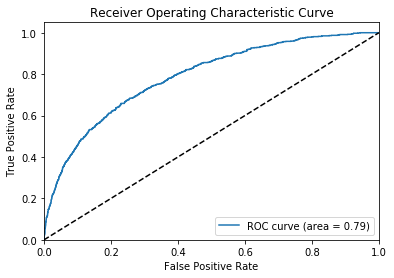

'AUC Score = 0.79'

In [16]:
prediction = logisticRegression.predict_proba(adult_icu.test.data.drop(["subject_id", "hadm_id", "icustay_id"], axis=1))
fpr, tpr, thresholds = roc_curve(adult_icu.test.target.values, prediction[:, 1])
auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
display("AUC Score = " + str(round(auc, 2)))

# Comment on model performance

In [17]:
accuracy = logisticRegression.score(test.data.drop(["subject_id", "hadm_id", "icustay_id"], axis=1), test.target) * 100
str(round(accuracy, 2)) + "%"

'90.84%'

In [18]:
feature_coefs = pd.Series(logisticRegression.coef_[0], index=train.data.drop(["subject_id", "hadm_id", "icustay_id"], axis=1).columns)
feature_coefs.sort_values(ascending=False, inplace=True)
display("Top 5 risk factors of mortality:")
display(feature_coefs.head(5).index.tolist())
display("Lowest 5 risk factors of mortality:")
display(feature_coefs.tail(5).index.tolist())

'Top 5 risk factors of mortality:'

['bilirubin', 'lactate', 'tempc_max', 'meanbp_mean', 'bun']

'Lowest 5 risk factors of mortality:'

['albumin', 'sysbp_min', 'platelet', 'tempc_mean', 'tempc_min']

# Explain what the above means

#### Part b:

In [19]:
dataset = pd.read_csv("~/csc2548_ml4h/adult_notes.gz", compression='gzip')
dataset = dataset[~pd.isnull(dataset.chartext)]

trainset = dataset[dataset.train == 1]
trainset.reset_index(drop=True, inplace=True)
trainset.pop("train")
target = trainset.pop("mort_icu")
train = Data(trainset, target)

testset = dataset[dataset.train == 0]
testset.reset_index(drop=True, inplace=True)
testset.pop("train")
target = testset.pop("mort_icu")
test = Data(testset, target)

adult_notes = Dataset(train, test)

display(adult_notes.train.data.shape)
display(adult_notes.test.data.shape)

(17956, 4)

(7923, 4)

In [24]:
def testfunc(x):
    return x + 2
testdf = pd.DataFrame([1,2,3,4,5], columns=["A"])
testdf.A = testfunc(testdf.A)
testdf.A
adult_notes.train.data.chartext.head().values.shape

(5,)

In [26]:
stopwordList = stopwords.words("english")

def tokenize(s):
    return [j for j in [re.sub("\W+", '', i) for i in word_tokenize(s.lower())] 
            if j not in stopwordList and j != '']

vectorizer = TfidfVectorizer(tokenizer=tokenize)
vectorizer.fit(adult_notes.train.data.chartext)
#testout = vectorizer.fit_transform(notes_train.data.head().chartext)
display(len(vectorizer.get_feature_names()))
#display(testout.toarray().shape)

#notes_train.data = notes_train.data.join(pd.DataFrame(testout.toarray(), columns=vectorizer.get_feature_names()))

#pd.DataFrame(testout.toarray(), columns=vectorizer.get_feature_names())
#notes_test.data.reset_index(drop=True, inplace=True)#print(vectorizer.get_feature_names()[0])

374355

In [53]:
import multiprocessing
from multiprocessing import Pool

num_cores = multiprocessing.cpu_count()
num_partitions = num_cores - 1 if num_cores > 1 else 1

def parallelize_dataframe(df, func):
    a = np.array_split(df, num_partitions)
    #del df
    pool = Pool(num_cores)
    #df = pd.concat(pool.map(func, [a,b,c,d,e]))
    df = sp.sparse.vstack(pool.map(func, a), format='csr')
    pool.close()
    pool.join()
    return df

In [54]:
vectorizer.get_feature_names()
#train_transformed = vectorizer.transform(adult_notes.train.data.chartext)
#test_transformed = vectorizer.transform(adult_notes.test.data.chartext)
# the below takes 6 minutes
train_transformed = parallelize_dataframe(adult_notes.train.data.chartext, vectorizer.transform)
test_transformed = parallelize_dataframe(adult_notes.test.data.chartext, vectorizer.transform)
train_transformed

<17956x374355 sparse matrix of type '<class 'numpy.float64'>'
	with 11665539 stored elements in Compressed Sparse Row format>

In [59]:
logisticRegression_b = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000)
logisticRegression_b.fit(train_transformed, adult_notes.train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

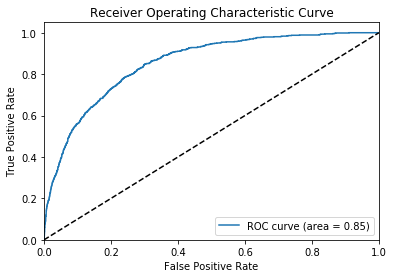

'AUC Score = 0.85'

In [60]:
prediction_b = logisticRegression_b.predict_proba(test_transformed)
fpr_b, tpr_b, thresholds_b = roc_curve(adult_notes.test.target.values, prediction_b[:, 1])
auc_b = metrics.auc(fpr_b, tpr_b)

plt.figure()
plt.plot(fpr_b, tpr_b, label='ROC curve (area = %0.2f)' % auc_b)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
display("AUC Score = " + str(round(auc_b, 2)))

In [61]:
accuracy_b= logisticRegression_b.score(test_transformed, adult_notes.test.target.values) * 100
str(round(accuracy_b, 2)) + "%"

'91.48%'

In [62]:
feature_coefs_b = pd.Series(logisticRegression_b.coef_[0], index=vectorizer.get_feature_names())
feature_coefs_b.sort_values(ascending=False, inplace=True)
display("Top 5 risk factors of mortality:")
display(feature_coefs_b.head(5).index.tolist())
display("Lowest 5 risk factors of mortality:")
display(feature_coefs_b.tail(5).index.tolist())

'Top 5 risk factors of mortality:'

['prognosis', 'cmo', 'corneal', 'dnr', 'family']

'Lowest 5 risk factors of mortality:'

['intact', 'mae', 'clear', 'diet', 'extubation']

#### Part c:

In [38]:
train_transformed = vectorizer.transform(adult_notes.train.data.head().chartext)
#notes_train.data = notes_train.data.join(pd.DataFrame(transformed.toarray(), columns=vectorizer.get_feature_names()))
train_transformed.toarray().shape
sa = sp.sparse.hstack((adult_notes.train.data.head().hadm_id[:,None],train_transformed))
sdf = pd.SparseDataFrame(sa, columns=(["hadm_id"]+vectorizer.get_feature_names()), default_fill_value=0)
sdf
#train.data.head()
#notes_train_transformed.A
#notes_test_transformed = vectorizer.transform(notes_test.data.chartext)
#notes_test.data = notes_test.data.join(pd.DataFrame(transformed.toarray(), columns=vectorizer.get_feature_names()))

# then transform and join notes_test
# then remove subject_id, hadm_id, icustay_id, chartext, and train logisticClassifier
# then test with notes_test (having removed similar) and get top 5 words/lowest 5 words, 
# ROC/AUC, plot, etc

,hadm_id,0,00,000,0000,00000100,00000700,00001700,0000313,00004,...,zysin,zysyn,zythro,zythromax,zyvo,zyvox,zyvoxzosynsteroids,zz,zzach,zzz8
0,145834.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,112213.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,194023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,109451.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,111970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
#notes_test_transformed = vectorizer.transform(notes_test.data.chartext)
#notes_test_transformed

<7923x375795 sparse matrix of type '<class 'numpy.float64'>'
	with 5034726 stored elements in Compressed Sparse Row format>